First we import the data into the memory

In [1]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc
# -- Click "restart runtime" in the runtime menu
! pip install matplotlib==3.1.3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.1
    Uninstalling matplotlib-3.5.1:
      Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gwpy 2.1.3 requires matplotlib>=3.3.0, but you have matplotlib 3.1.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# Downloading the data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf

--2022-02-14 22:17:23--  https://www.gw-openscience.org/s/workshop3/challenge/challenge2.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4025842 (3.8M)
Saving to: ‘challenge2.gwf’

challenge2.gwf      100%[===================>]   3.84M  1.34MB/s    in 2.9s    

2022-02-14 22:17:26 (1.34 MB/s) - ‘challenge2.gwf’ saved [4025842/4025842]



In [3]:
# -- for gwpy 
from gwpy.timeseries import TimeSeries
gwpy_strain = TimeSeries.read('challenge2.gwf', channel="H1:CHALLENGE2")

In [4]:
# -- for pycbc
from pycbc import frame
pycbc_strain = frame.read_frame('challenge2.gwf', 'H1:CHALLENGE2')

Let's look at the data as well as the sample rate

In [5]:
print(gwpy_strain)
print(gwpy_strain.sample_rate)

TimeSeries([ 8.75332715e-22,  1.27597248e-22,  1.88838802e-22,
            ..., -1.91886478e-23, -2.10989354e-22,
             2.30287965e-22]
           unit: ct,
           t0: -64.0 s,
           dt: 0.000244140625 s,
           name: H1:CHALLENGE2,
           channel: H1:CHALLENGE2)
4096.0 Hz


Let's now plot the data in the time-domain to get a better visualization of it

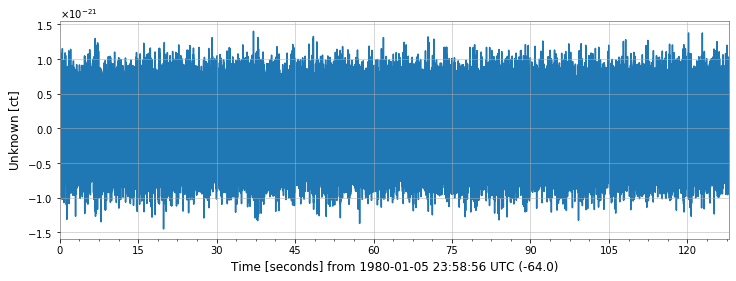

In [6]:
%matplotlib inline
plot = gwpy_strain.plot()

We plot a spectrogram to identify the signal

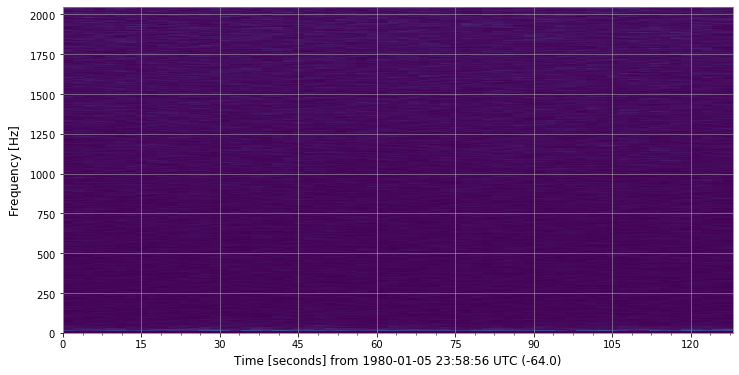

In [7]:
specgram = gwpy_strain.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()

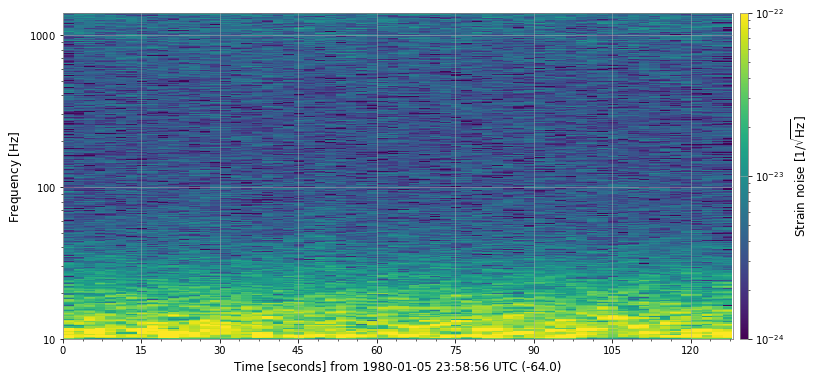

In [8]:
# adjust colour scale
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
ax.colorbar(
    clim=(1e-24, 1e-22),
    norm="log",
    label=r"Strain noise [$1/\sqrt{\mathrm{Hz}}$]",
)
plot  # refresh

As no signal can be observed from this spectrogram, we can calculate the q-transform. The frequency range is also determined in such a way that the signal can be observed within an appropriate range.

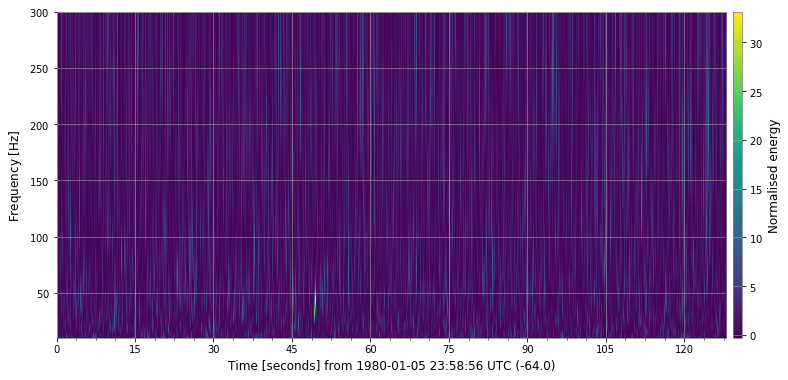

In [10]:
# time frequency representation
hq = gwpy_strain.q_transform(frange=(10, 500))
plot = hq.plot()
plot.colorbar(label="Normalised energy")

Here we see that there is something resembling a signal between approximately 45 and 55 sec. 
Let's try to have a closer look at it by zooming in and changing the q-range.

In [11]:
epoch = gwpy_strain.epoch

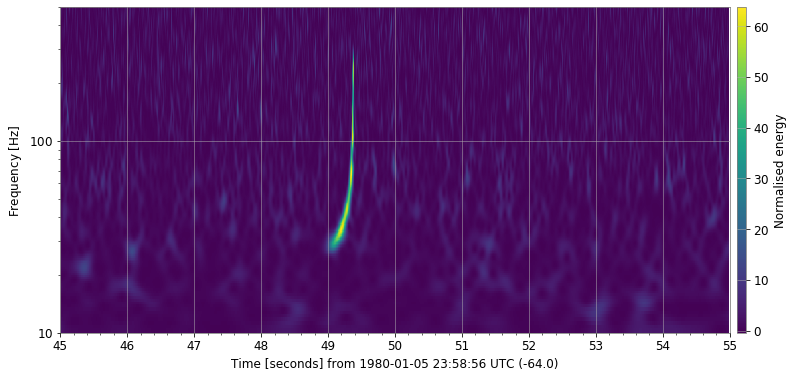

In [16]:
#take a smaller time-range to see the event better
hq = gwpy_strain.q_transform(frange=(10, 500), qrange=(10, 300), outseg=(-19,-9)) 
plot = hq.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.set_epoch(epoch)
ax.colorbar(label="Normalised energy")

We can now confidently assume that there is a signal around 49 sec.

2. Generating and plotting the template waveform

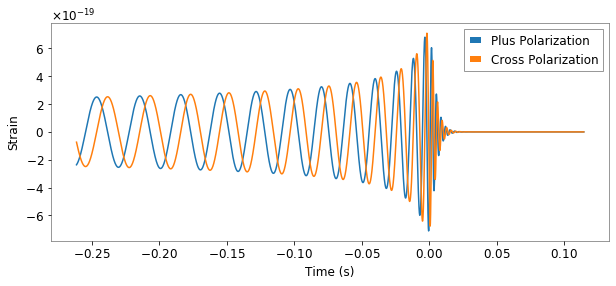

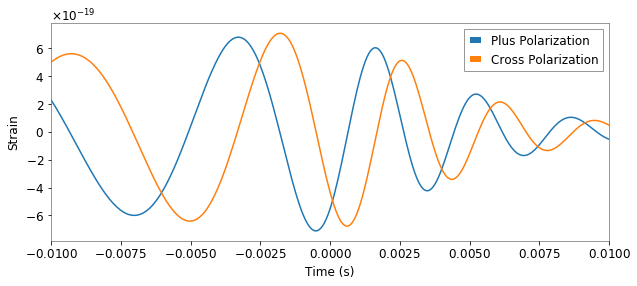

In [12]:
# The outputs of this function are the "plus" and "cross" polarizations 
# of the gravitational-wave signal as viewed from the line of sight at 
# a given source inclination (assumed face-on, i.e. zero inclination
# if not provided)
%matplotlib inline
from pycbc.waveform import get_td_waveform
import pylab

hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=30,
                         mass2=30,
                         delta_t=1.0/16384,
                         f_lower=30,
                         spin1z=0,
                         spin2z=0)

pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time
pylab.figure(figsize=pylab.figaspect(0.4))
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

3. Calculating the PSD of the data and plotting it on a log-log scale

In [17]:
samplerate = pycbc_strain.sample_rate
nfrequency = samplerate/2
# deltaf = 1.0 / 128
samplelength = 4
print('The sampling rate is', samplerate, 'and the Nyquist frequency is', nfrequency, '.')

The sampling rate is 4096.0 and the Nyquist frequency is 2048.0 .


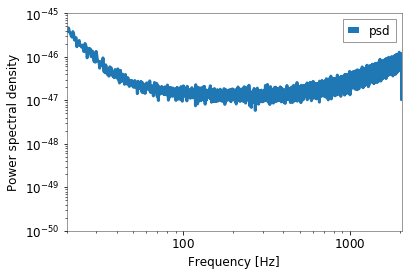

In [18]:
psd = pycbc_strain.psd(samplelength)
# plot it:

pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='psd')
pylab.xlim(xmin=20, xmax=2048)
pylab.ylim(1e-50, 1e-45)
pylab.xlabel('Frequency [Hz]')
pylab.ylabel('Power spectral density')
pylab.legend()
pylab.grid()
pylab.show()

We are filtering out the frequencies below 15 Hz because they do not represent a signal. Then we downsample the data to 2048 Hz (Nyquist frequency)
and plot that

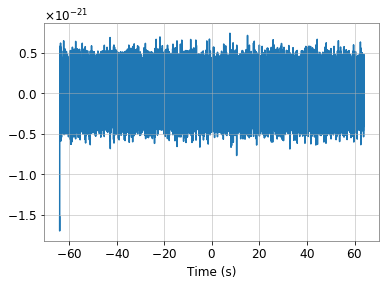

In [20]:
from pycbc import frame
from pycbc.filter import matched_filter
import numpy
import pylab
from pycbc.filter import resample_to_delta_t, highpass

# Remove the low frequency content and downsample the data to 2048Hz
pycbc_strain = highpass(pycbc_strain, 15.0)
pycbc_strain = resample_to_delta_t(pycbc_strain, 1.0/2048)

pylab.plot(pycbc_strain.sample_times, pycbc_strain)
pylab.xlabel('Time (s)')
pylab.show()

Conditioning the data, so in our case removing the first and last second of the data

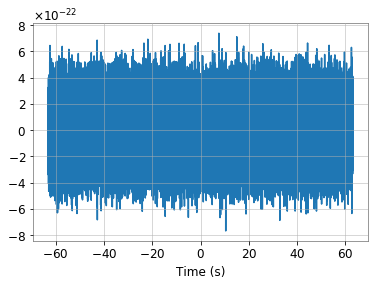

In [21]:
conditioned = pycbc_strain.crop(1,1) # cropping first and last second of the data

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

We can now estimate the PSD for the conditioned data

In [22]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series since the data length is 128 which is divisible by 4
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [23]:
from pycbc.waveform import get_td_waveform

m = 30 # Solar masses
s = 0 # the spin is 0
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=conditioned.delta_t,
                     f_lower=20,
                     spin1z=s,
                     spin2z=s)

# Resize the vector to match our data
hp.resize(len(conditioned))

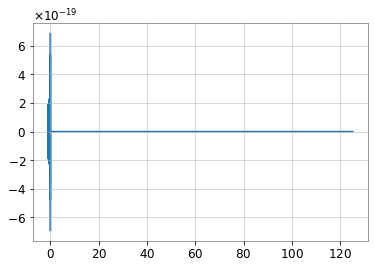

In [24]:
pylab.plot(hp.sample_times, hp)

Here is the template of the conditioned data

Text(0, 0.5, 'Strain')

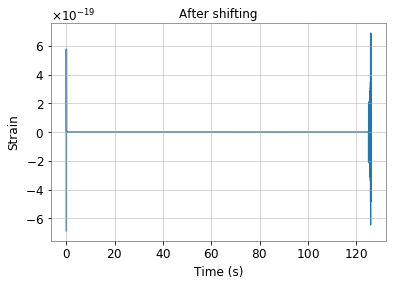

In [25]:
# Let's plot the signal before and after shifting
template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

4. Using the template waveform and PSD we calculate the SNR time series and plot it. While doing the matched filtering, we notice that it gives us a complex number which is the reason why we take the abs() value of the SNR.
Max SNR is what is printed underneath the graph.

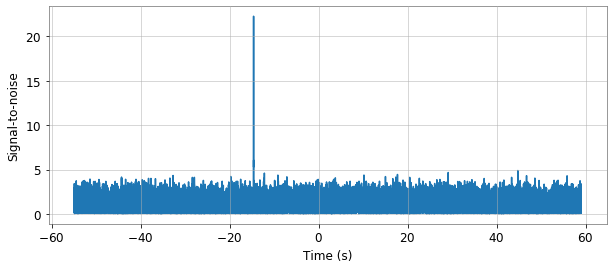

We found a signal at -14.6328125s with SNR 22.2540688085927


In [26]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

5. The matched filter SNR of the signal is indicated underneath the diagram. We see that it is greater than 8 meaning that we can be sure that a signal is present. The signal has been found to be at -14.6 sec which, considering the shift in the x-axis, corresponds to what was found in the q-transform.